# Activity recognition on the Capture24 dataset

## Data augmentation

Data augmentation is a straighforward way to artificially increase the size
of the dataset, which can be useful when the dataset is small or when
using large models such as deep neural networks. It relies on generating
variations of each instance in the dataset by applying several transformations on it.

Not any transformation is applicable: For example, for image recognition it may not matter if the image is rotated, flipped or stretched; but for digits and letters recognition, flipping the image may not be helpful.
The key is to find *invariances* in the data that are applicable for our learning task.

###### Setup

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

 ###### Load dataset and hold out some instances for testing

To highlight the utility of data augmentation in small datasets, let us constrain ourselves to only *five* participants:

In [2]:
data = np.load('capture24.npz', allow_pickle=True)
# data = np.load('capture24_small.npz', allow_pickle=True)
mask = np.isin(data['pid'], [1, 2, 3, 4, 5])  # take only five participants
X_feats, y, pid, time = \
    data['X_feats'][mask], data['y'][mask], data['pid'][mask], data['time'][mask]
print("Contents of capture24.npz:", data.files)

# Hold out some participants for testing the model
pids_test = [2, 3]  # participants 2 & 3
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
X_train, y_train, pid_train, time_train = \
    X_feats[mask_train], y[mask_train], pid[mask_train], time[mask_train]
X_test, y_test, pid_test, time_test = \
    X_feats[mask_test], y[mask_test], pid[mask_test], time[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (6025, 125)
Shape of X_test: (4991, 125)


 ###### Baseline

Train the random forest and evaluate on the held out participants

*Note: this takes a few minutes*

In [3]:
# Training
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, verbose=True)
classifier.fit(X_train, y_train)
Y_oob = classifier.oob_decision_function_
prior, emission, transition = utils.train_hmm(Y_oob, y_train)

# Testing
y_test_pred = utils.viterbi(classifier.predict(X_test), prior, transition, emission)
print("\n--- Baseline performance ---")
utils.print_scores(utils.compute_scores(y_test, y_test_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished



--- Baseline performance ---
Accuracy score: 0.9022240032057703
Balanced accuracy score: 0.6371540652875727
Cohen kappa score: 0.8432713529210466

Per-class recall scores:
sleep      : 0.9937759336099585
sedentary  : 0.959927960378208
tasks-light: 0.0
walking    : 0.45483870967741935
moderate   : 0.7772277227722773

Confusion matrix:
 [[1916    8    0    4    0]
 [  65 2132    0   20    4]
 [  17   98    0   13    0]
 [   0  105    0  141   64]
 [   0   40    0   50  314]]


## Robustness to unforseen circumstances

What would our performance be if our two left-out participants happened to wear the device with a different orientation?
For example: Suppose that all our training participants wore the device on their right hand, then how would our model perform on participants that wore the device on their left hand?
This scenario corresponds to a 180 degrees rotation around the z-axis:
<img src="ax3_orientation.jpg" width="400"/>
Let's generate a pseudo-test set simulating this scenario. In the following,
we first load the raw triaxial accelerometer data so that we can perform the
rotation on it, then we use our utility function to extract hand-crafted features (see
`utils.Extractor`) on the rotated raw data.

In [4]:
# Load the raw triaxial data to perform the rotation on it
X_raw = np.load('X_raw.npy', mmap_mode='r')
# X_raw = np.load('X_raw_small.npy')
# Grab the five participants and hold out those for testing
# X_raw[mask_train] and X_raw[mask_test] if you like to live dangerously
X_raw = utils.ArrayFromMask(X_raw, mask)
X_raw_train = utils.ArrayFromMask(X_raw, mask_train)
X_raw_test = utils.ArrayFromMask(X_raw, mask_test)

# Initialize feature extractor -- this needs to be done only once
extractor = utils.Extractor()

print("Extracting features on pseudo-test set...")
X_test_rot = np.empty_like(X_test)
y_test_rot = y_test.copy()
for i in tqdm(range(X_raw_test.shape[0])):
    # Rotate instance around z-axis and extract features
    x = X_raw_test[i].copy()
    x[0,:] *= -1
    x[1,:] *= -1
    X_test_rot[i] = extractor.extract(x)

Extracting features on pseudo-test set...


 ###### How does the baseline model perform on the pseudo-set? 

In [5]:
y_test_rot_pred = utils.viterbi(
    classifier.predict(X_test_rot), prior, transition, emission)
print("\n--- Performance of baseline model on pseudo-test set ---")
utils.print_scores(utils.compute_scores(y_test_rot, y_test_rot_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished



--- Performance of baseline model on pseudo-test set ---
Accuracy score: 0.48787818072530553
Balanced accuracy score: 0.49410586761645625
Cohen kappa score: 0.22269253492126628

Per-class recall scores:
sleep      : 0.975103734439834
sedentary  : 0.01936064835659613
tasks-light: 0.078125
walking    : 0.667741935483871
moderate   : 0.7301980198019802

Confusion matrix:
 [[1880   39    0    9    0]
 [2131   43    2   45    0]
 [  27   63   10   28    0]
 [  38    2   14  207   49]
 [  13   14    1   81  295]]


The model score has dropped drastically.
Let's visualize the predicted activities for participant #3 and the pseudo-participant #3 (with rotated device):

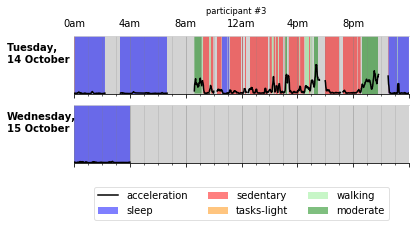

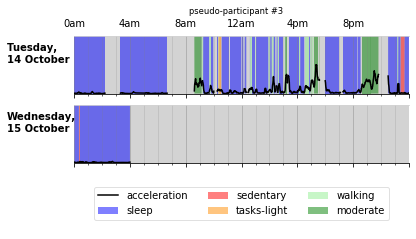

In [6]:
fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_pred[pid_test==3], time_test[pid_test==3]
)
fig.suptitle('participant #3', fontsize='small')
fig.show()

fig, _ = utils.plot_activity(
    X_test_rot[pid_test==3][:,0], y_test_rot_pred[pid_test==3], time_test[pid_test==3]
)
fig.suptitle('pseudo-participant #3', fontsize='small')
fig.show()

As we see, the activity plot has changed significantly &mdash; the model is not
robust to participants wearing the device differently.
Ideally, we would like our model to perform well regardless of
how the device was worn.

###### Data augmentation

We can incorporate the desired invariance by simply augmenting our training set and re-training the model:

In [7]:
print("\nExtracting features on pseudo-training set...")
X_train_rot = np.empty_like(X_train)
y_train_rot = y_train.copy()
for i in tqdm(range(X_raw_train.shape[0])):
    # Rotate instance around z-axis and extract features
    x = X_raw_train[i].copy()
    x[0,:] *= -1
    x[1,:] *= -1
    X_train_rot[i] = extractor.extract(x)

# Add in the "new data" to training set
X_train = np.concatenate((X_train, X_train_rot))
y_train = np.concatenate((y_train, y_train_rot))
print("Shape of new augmented X_train:", X_train.shape)


Extracting features on pseudo-training set...



Shape of new augmented X_train: (12050, 125)


 ###### Re-train the model on the augmented training set

*Note: this takes a few minutes*

In [8]:
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, verbose=True)
classifier.fit(X_train, y_train)
Y_oob = classifier.oob_decision_function_
prior, emission, transition = utils.train_hmm(Y_oob, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


 ###### Re-evaluate the model 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished



--- Performance of re-trained model on the original test set ---
Accuracy score: 0.9036265277499499
Balanced accuracy score: 0.6589090426817158
Cohen kappa score: 0.8460255255523942

Per-class recall scores:
sleep      : 0.9761410788381742
sedentary  : 0.9617289509230077
tasks-light: 0.0
walking    : 0.5967741935483871
moderate   : 0.7599009900990099

Confusion matrix:
 [[1882   41    0    5    0]
 [  57 2136    0   28    0]
 [   0  108    0   20    0]
 [   0   86    0  185   39]
 [   0   37    0   60  307]]

--- Performance of re-trained model on the pseudo-test set ---


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy score: 0.9016229212582649
Balanced accuracy score: 0.6578580148863831
Cohen kappa score: 0.8428967207497371

Per-class recall scores:
sleep      : 0.9766597510373444
sedentary  : 0.9581269698334084
tasks-light: 0.0
walking    : 0.6193548387096774
moderate   : 0.7351485148514851

Confusion matrix:
 [[1883   38    0    7    0]
 [  62 2128    0   31    0]
 [   0  108    0   20    0]
 [   0   86    0  192   32]
 [   0   40    0   67  297]]


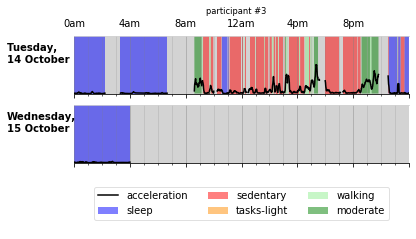

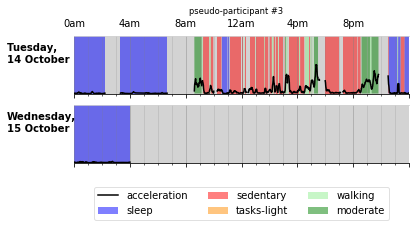

In [9]:
print("\n--- Performance of re-trained model on the original test set ---")
y_test_pred = utils.viterbi(classifier.predict(X_test), prior, transition, emission)
utils.print_scores(utils.compute_scores(y_test, y_test_pred))

print("\n--- Performance of re-trained model on the pseudo-test set ---")
y_test_rot_pred = utils.viterbi(classifier.predict(X_test_rot), prior, transition, emission)
utils.print_scores(utils.compute_scores(y_test_rot, y_test_rot_pred))

fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_pred[pid_test==3], time_test[pid_test==3]
)
fig.suptitle('participant #3', fontsize='small')
fig.show()

fig, _ = utils.plot_activity(
    X_test_rot[pid_test==3][:,0], y_test_rot_pred[pid_test==3], time_test[pid_test==3]
)
fig.suptitle('pseudo-participant #3', fontsize='small')
fig.show()

As we see, by data-augmenting the training set with the desired invariance
the model prediction is more robust to wear variations.

###### Ideas

- What other invariances should we want our model to learn?
- Re-run the notebook on the whole dataset. Can you explain the reduced discrepancy?